# Recurrent Neural Networks

Natural language processing (NLP) is the practice of identify sequence patterns from language, to deduce the meaning behind the statement. In short, NLP has the goal of derviging information out of natural language (could be sequences text or speech). Another common term for NLP problems is sequence to sequence problems (seq2seq).

The purpose of this notebook is to download, prepare, and use a text dataset to build out multiple recurrent neural network (RNN) models to make predictions from the text. Additionally, I will create a model from an already pre-trained model on TensorFlow Hub.

The dataset I am going to use is Kaggle's introduction to NLP dataset (text samples of Tweets that predict as disaster or not disater).
* https://www.kaggle.com/competitions/nlp-getting-started

NOTE: Other sequence problems may include something like time series forecasting.

## Imports

In [1]:
from dataclasses import dataclass, asdict
import io
import os
import pathlib
import random
import sys
from typing import Dict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from py_learning_toolbox.deep_learning import analysis, modeling
import random
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
import tensorflow as tf

## Helper Functions

## Download and Analyze Data

In [2]:
# Image dataset location
data_directory = pathlib.Path('./data/nlp_getting_started')
test_file = data_directory / 'test.csv'
train_file = data_directory / 'train.csv'

In [3]:
# Visualizing the text dataset
train_data = pd.read_csv(str(train_file))
test_data = pd.read_csv(str(test_file))
train_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
# Lets shuffle the training data
train_data_shuffled = train_data.sample(frac=1, random_state=42)
train_data_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [5]:
# Lets look at 10 random tweets and whether each one was a disaster or not
for i in range(10):
    row = train_data_shuffled.iloc[random.randint(0, len(train_data_shuffled))]
    print(f"Target: ({'Disaster' if row['target'] else 'Not Disaster'})")
    print(row['text'])
    print('\n', '-' * 40, '\n')

Target: (Disaster)
WFP - WFP Delivers Food To 165000 Bangladesh Flood Victims After Tropical Cyclone Komen: DHAKA ÛÒThe United Na... http://t.co/fukbBeDfGx

 ---------------------------------------- 

Target: (Not Disaster)
saving babies from burning buildings soaking cake in a shit tonne of alcohol mat is a man after my own heart ?? #GBBO

 ---------------------------------------- 

Target: (Not Disaster)
@danagould @WaynesterAtl I agree with background checks. I just think guns or weapons in general are the great equalizer.

 ---------------------------------------- 

Target: (Not Disaster)
OMEGA MEN Writer Explores Terrorism Religion In an 'Epic KYLE RAYNER Story' https://t.co/utc7pdIdfo via @Newsarama

 ---------------------------------------- 

Target: (Disaster)
#forbes #europe China's Stock Market Crash: Are There Gems In The Rubble? http://t.co/C0SlAbBP7j

 ---------------------------------------- 

Target: (Disaster)
Truck crash on 40w at US70 in Lebanon is a fatality. Very s

In [6]:
# Lets look at the number of each target (disaster or not a disaster)
train_data_shuffled.target.value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

## Preparing Data

To prep this data, there are a few things I need to do to get everything ready to build out my models.

1. Shuffle the training data set.
2. Split the training data set into a training and validation set (go to use 10% of the training data as the validation data).
3. Need to convert text into numbers.

In [7]:
# Lets shuffle the training data
train_data_shuffled = train_data.sample(frac=1, random_state=42)
train_data_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [8]:
# Splitting the train data to split into training and validation datasets
train_sentences, val_sentences, train_labels, val_labels = train_test_split(
    train_data_shuffled['text'].to_numpy(),
    train_data_shuffled['target'].to_numpy(),
    test_size=0.1,
    random_state=42)

len(train_sentences), len(val_sentences), len(train_labels), len(val_labels)

(6851, 762, 6851, 762)

In [9]:
# Verify the split worked as expected
train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object),
 array([0,

#### TextVectorization Layer (To be Used in Models)

When dealing with a text problem, one of the first things to do before building a model is to convert text to numbers. There are a few ways to do this:

* Tokenization - direct mapping of token (a token could be a word or a character) to a number.
* Embedding - create a matrix of featyre vector for each token (the size of the feature vector can be defined and this embedding can be learned).

In [10]:
# Find average number of tokens
round(sum([len(i.split()) for i in train_sentences]) / len(train_sentences))

15

In [11]:
# Setup text vectorization params
max_vocab_length = 10000  # Max words to have in our vocab
max_length = 15  # Max length our sequence will be

In [12]:
# Setting up a text vectorization layer (tokenization)
text_vectorizer = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=max_vocab_length,  # How many words in the vocabulary (None sets as no maximum number of tokens)
    output_mode='int',
    output_sequence_length=max_length)  # Padds (adds 0's to end of number) to make all the same length

2023-08-28 17:26:44.879648: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-08-28 17:26:44.879681: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-08-28 17:26:44.879685: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-08-28 17:26:44.879926: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-08-28 17:26:44.879946: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [13]:
# Adapt the vectorizer to the training data
text_vectorizer.adapt(train_sentences)

2023-08-28 17:26:45.020555: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [14]:
# Verify the text vectorizer was adapted correctly
sample_sentence = 'There\'s a flood in my street!'
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [15]:
# Choose a random sentence from the train data and encode it
rand_i = random.randint(0, len(train_sentences))
print(f'Sentence: {train_sentences[rand_i]}')
print(f'Vectorized: {text_vectorizer([train_sentences[rand_i]])}')

Sentence: @_gaabyx we got purple activist I thought it was a drought
Vectorized: [[   1   46  100 2334    1    8  497   15   23    3  377    0    0    0
     0]]


In [16]:
# Getting the words in the vocab from the training data
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5]
least_common_5_words = words_in_vocab[-5:]
len(words_in_vocab), top_5_words, least_common_5_words

(10000,
 ['', '[UNK]', 'the', 'a', 'in'],
 ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1'])

#### Creating Embedding Layer (To be Used in Models)

To make our embedding layer, I am going to use TensorFlow's `Embedding` layer. 

The parameters we care most about for our embedding layer are:

* `input dim` -  The size of the vocabulary
* `output dim` - The size of the output embedding vector, for example, a size of 100 mean each token would be represented by a vector of length 100.
* `input_length` - The length of the sequences being passed to the embedding layer.

In [17]:
embedding = tf.keras.layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,  # GPU's work well when number is divisible by 8
                                     input_length=max_length)
embedding

In [18]:
# Verify the embedding layer worked
random_sentence = random.choice(train_sentences)
embedded_sentence = embedding(text_vectorizer([random_sentence]))
print('Sentence: \n', random_sentence)
print('Embedded Version: \n', embedded_sentence)

Sentence: 
 Strict liability in the context of an airplane accident - http://t.co/gibyQHhKpk
Embedded Version: 
 tf.Tensor(
[[[-0.04447868  0.01633802  0.02735605 ... -0.04693479 -0.04859321
   -0.0190748 ]
  [ 0.01405123 -0.04414525  0.04743428 ... -0.00320438  0.04701046
   -0.04118485]
  [ 0.0402406  -0.03156954 -0.0125141  ... -0.03725331  0.0023211
    0.03838572]
  ...
  [-0.02989845  0.02957496 -0.00804364 ... -0.0215206  -0.0012041
   -0.01756949]
  [-0.02989845  0.02957496 -0.00804364 ... -0.0215206  -0.0012041
   -0.01756949]
  [-0.02989845  0.02957496 -0.00804364 ... -0.0215206  -0.0012041
   -0.01756949]]], shape=(1, 15, 128), dtype=float32)


## Experiments

To experiment and identify the best model, I am going to run the following experiments with the corresponding model to analyze the difference between the different types of models for modeling sequence based problems.

1. Naive Bayes with TF-IDF encoder (baseline model) NOTE: this is not a Deep Learning model
2. Feed-forward neural network (dense model)
3. LSTM (RNN)
4. GRU (RNN)
5. Bidirection-LSTM (RNN)
6. 1D Convolutional Neural Network
7. TensorFlow Hub Pretrained Feature Extractor
8. TensorFlow Hub Pretrained Feature Extractor (10% of Data)

In [19]:
# Setup
TENSORBOARD_LOGS_DIR = pathlib.Path('logs/disaster_tweets')
CHECKPOINTS_DIR = pathlib.Path('checkpoints/disaster_tweets')
MODELS_DIR = pathlib.Path('models/disaster_tweets')

### Model-0 (Baseline Model): Naive Bayes Model

As a baseline model, I am going to use SKLearn's Multinomial Naive Bayes algorithm using the TF-IDF formuila to convert words to numbers. This model will be used to compare the DL models against to judge performance.

NOTE: It's common practice to use non-LD algorithms as a baseline because of their speed and then later using DL to see if you can improve upon them.

In [20]:
# Building out the baseline model

# Build Model
model_0 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB()),
])

# Fit Model
model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [21]:
# Evaluate model (SKlearn uses accuracy as the metric)
baseline_score = model_0.score(val_sentences, val_labels)
baseline_score  # Accuracy

0.7926509186351706

In [22]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

In [23]:
baseline_results = analysis.classification.generate_prediction_metrics(val_labels, baseline_preds)
baseline_results

PredictionMetrics(accuracy=0.7926509186351706, precision=0.8111390004213173, recall=0.7926509186351706, f1=0.7862189758049549)

### Model-1: Feed Forward Dense Model

The first test I am going to run against my baseline model is to use the traditional Dense DL model.

In [24]:
# Build model
inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string) # Inputs are 1 dimensional strings
x = text_vectorizer(inputs)  # Turn the input text into numbers
x = embedding(x)  # Embed the text
x = tf.keras.layers.GlobalAveragePooling1D()(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)  # Create the output layer

model_1 = tf.keras.models.Model(inputs, outputs, name='DenseModel')
model_1.summary()

Model: "DenseModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 15)                0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1280129 (4.88 MB)
Trainable params: 128012

In [25]:
# Compile Model
model_1.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [26]:
# Setup Callbacks
tensorboard_callback_1 = modeling.callbacks.generate_tensorboard_callback('dense-model', str(TENSORBOARD_LOGS_DIR))

# Fit the model
model_1_history = model_1.fit(x=train_sentences,
            y=train_labels,
            epochs=5,
            validation_data=(val_sentences, val_labels),
            callbacks=[tensorboard_callback_1])

INFO:py_learning_toolbox.deep_learning.modeling.callbacks:TensorBoard callback created.


Epoch 1/5


2023-08-28 17:26:45.712176: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


215/215 [==============================] - 3s 14ms/step - loss: 0.6117 - accuracy: 0.6895 - val_loss: 0.5337 - val_accuracy: 0.7598
Epoch 2/5
  1/215 [..............................] - ETA: 2s - loss: 0.4871 - accuracy: 0.8438

2023-08-28 17:26:48.805619: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


215/215 [==============================] - 2s 11ms/step - loss: 0.4420 - accuracy: 0.8180 - val_loss: 0.4704 - val_accuracy: 0.7887
Epoch 3/5
215/215 [==============================] - 2s 10ms/step - loss: 0.3484 - accuracy: 0.8581 - val_loss: 0.4559 - val_accuracy: 0.7966
Epoch 4/5
215/215 [==============================] - 2s 10ms/step - loss: 0.2854 - accuracy: 0.8897 - val_loss: 0.4667 - val_accuracy: 0.7900
Epoch 5/5
215/215 [==============================] - 2s 11ms/step - loss: 0.2393 - accuracy: 0.9086 - val_loss: 0.4816 - val_accuracy: 0.7808


In [27]:
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 4ms/step - loss: 0.4816 - accuracy: 0.7808


[0.48160988092422485, 0.7808399200439453]

In [28]:
# Get prediction probabilities
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs[:10]

24/24 [==============================] - 0s 2ms/step


2023-08-28 17:26:58.334518: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


array([[0.3331611 ],
       [0.7276712 ],
       [0.9979023 ],
       [0.14561696],
       [0.11085988],
       [0.94345176],
       [0.9303112 ],
       [0.9924966 ],
       [0.96197504],
       [0.3015671 ]], dtype=float32)

In [29]:
# Convert prediction probabilities to 1 or 0
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))
model_1_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [30]:
model_1_results = analysis.classification.generate_prediction_metrics(val_labels, model_1_preds)
model_1_results

PredictionMetrics(accuracy=0.7808398950131233, precision=0.7848699684611963, recall=0.7808398950131233, f1=0.7779792730264676)

In [31]:
# Analyze data against the baseline data
np.array(list(dict(model_1_results).values())) >= np.array(list(dict(baseline_results).values()))

array([False, False, False, False])

#### Findings

Looks like the baseline outperformed the simple Dense DL model.

#### Visualizing the Learned Embeddings

To visualize the embedding matrix, TensorFlow has a handy tool called projector that visualizes the matrix.

NOTE: To utilize the projector tool, you need to create a vectors.tsv and metadata.tsv that will be uploaded to the projector website linked below.

* https://www.tensorflow.org/text/guide/word_embeddings
* https://projector.tensorflow.org/

In [32]:
# Get the weight matrix of embedding layer
# These are the numerical representation of each token in our training data, learned for 5 epochs.
embed_weights_1 = model_1.get_layer('embedding').get_weights()[0]
embed_weights_1

array([[-0.04077354,  0.02332817,  0.0010654 , ..., -0.01173849,
         0.00839117, -0.00802486],
       [-0.0001722 ,  0.01925414, -0.04033769, ...,  0.04278829,
         0.0165825 ,  0.00488503],
       [-0.04562515,  0.03561248,  0.03521897, ...,  0.01214127,
        -0.02458713, -0.02225271],
       ...,
       [ 0.00816353,  0.0345163 ,  0.00548022, ..., -0.02533958,
         0.03551415, -0.03385993],
       [-0.01410693, -0.06379256,  0.04922031, ..., -0.00013135,
         0.04547554,  0.07382385],
       [-0.1004874 , -0.07358213,  0.06906305, ...,  0.08546294,
         0.05537951,  0.05981688]], dtype=float32)

In [33]:
# Looking at the shape, the embedding matrix is 10,000 x 128 matrix
# (every token in vocabulary has 128 params to better represent each token)
embed_weights_1.shape

(10000, 128)

In [34]:
# Create embedding files (These will be uploaded to the embedding projector)
filepath = f'{str(TENSORBOARD_LOGS_DIR)}/dense-model/embedding_projector'
analysis.export.export_embedding_projector_data(embed_weights_1, words_in_vocab, filepath, True)

### Model-2: LSTM

LSTM (Long Short Term Memory) is one of the most popular RNN models.

Our structure of an RNN typically looks like this:

```
Input (text) -> Tokenize -> Embedding -> Layers (RNN's/Dense) -> Output
```

In [35]:
# Create an LSTM Model

# Build model
inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string) # Inputs are 1 dimensional strings

x = text_vectorizer(inputs)  # Turn the input text into numbers
x = embedding(x)  # Embed the text
# x = tf.keras.layers.LSTM(64, return_sequences=True)(x)  # when you're stacking RNN cells together, you need to set return sequences to True
x = tf.keras.layers.LSTM(64)(x)
# x = tf.keras.layers.Dense(64, activation='relu')(x)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model_2 = tf.keras.models.Model(inputs, outputs, name='Model2LSTM')
model_2.summary()

Model: "Model2LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 15)                0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1329473 (5.07 MB)
Trainable params: 1329473 (5.07 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

In [36]:
# Compile the model
model_2.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [37]:
# Setup Callbacks
tensorboard_callback_2 = modeling.callbacks.generate_tensorboard_callback('lstm-model', str(TENSORBOARD_LOGS_DIR))

# Fit the Model
model_2_history = model_2.fit(train_sentences,
            train_labels,
            epochs=5,
            validation_data=(val_sentences, val_labels),
            callbacks=[tensorboard_callback_2])

INFO:py_learning_toolbox.deep_learning.modeling.callbacks:TensorBoard callback created.


Epoch 1/5


2023-08-28 17:26:59.443647: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-28 17:26:59.577510: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  1/215 [..............................] - ETA: 2:59 - loss: 0.6784 - accuracy: 0.7188

2023-08-28 17:26:59.716769: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


215/215 [==============================] - ETA: 0s - loss: 0.2263 - accuracy: 0.9209

2023-08-28 17:27:03.737006: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-28 17:27:03.788353: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


215/215 [==============================] - 5s 20ms/step - loss: 0.2263 - accuracy: 0.9209 - val_loss: 0.5442 - val_accuracy: 0.7822
Epoch 2/5
215/215 [==============================] - 3s 16ms/step - loss: 0.1593 - accuracy: 0.9429 - val_loss: 0.5943 - val_accuracy: 0.7730
Epoch 3/5
215/215 [==============================] - 3s 15ms/step - loss: 0.1288 - accuracy: 0.9524 - val_loss: 0.6879 - val_accuracy: 0.7822
Epoch 4/5
215/215 [==============================] - 3s 16ms/step - loss: 0.1050 - accuracy: 0.9612 - val_loss: 0.8916 - val_accuracy: 0.7782
Epoch 5/5
215/215 [==============================] - 3s 15ms/step - loss: 0.0857 - accuracy: 0.9661 - val_loss: 0.9811 - val_accuracy: 0.7769


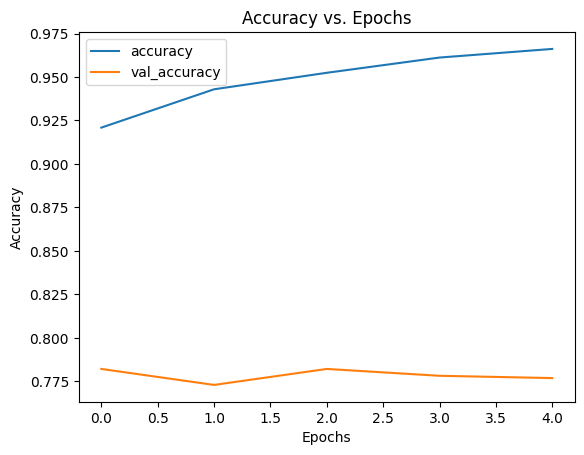

In [38]:
analysis.history.plot_history(model_2_history, 'accuracy')

In [39]:
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs[:10]

12/24 [==============>...............] - ETA: 0s

2023-08-28 17:27:17.762828: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-28 17:27:17.800815: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


24/24 [==============================] - 0s 5ms/step


array([[7.1222722e-03],
       [9.0038019e-01],
       [9.9974602e-01],
       [1.7290855e-02],
       [4.9464189e-04],
       [9.9937481e-01],
       [9.6263140e-01],
       [9.9983609e-01],
       [9.9973696e-01],
       [3.0931339e-01]], dtype=float32)

In [40]:
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [41]:
model_2_results = analysis.classification.generate_prediction_metrics(val_labels, model_2_preds)
model_2_results

PredictionMetrics(accuracy=0.7769028871391076, precision=0.7789562668302826, recall=0.7769028871391076, f1=0.7747522807746444)

In [42]:
# Analyze data against the baseline data
np.array(list(dict(model_1_results).values())) >= np.array(list(dict(baseline_results).values()))

array([False, False, False, False])

#### Findings

Looks like the baseline model is still outperforming the LSTM model.

### Model-3: GRU

Another popular and effective RNN component is the FRU or gated recurrent unit. The GRU cell has similar features to an LSTM cell, but has less parameters.

In [43]:
# Create the GRU model

inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = tf.keras.layers.GRU(64)(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model_3 = tf.keras.models.Model(inputs, outputs, name='Model3GRU')
model_3.summary()

Model: "Model3GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 15)                0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1317313 (5.03 MB)
Trainable params: 1317313 (5.03 MB)
Non-trainable params: 0 (0.00 Byte)
___________________

In [44]:
# Compile the Model
model_3.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [45]:
# Fit the model with Tensorboard callback
# Setup Callbacks
tensorboard_callback_3 = modeling.callbacks.generate_tensorboard_callback('gru-model', str(TENSORBOARD_LOGS_DIR))

# Fit Model
model_3_history = model_3.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[tensorboard_callback_3])

INFO:py_learning_toolbox.deep_learning.modeling.callbacks:TensorBoard callback created.


Epoch 1/5


2023-08-28 17:27:18.651955: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-28 17:27:18.772195: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  1/215 [..............................] - ETA: 2:59 - loss: 0.7078 - accuracy: 0.2812

2023-08-28 17:27:18.922232: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


215/215 [==============================] - ETA: 0s - loss: 0.1698 - accuracy: 0.9326

2023-08-28 17:27:23.119303: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-28 17:27:23.169391: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


215/215 [==============================] - 5s 21ms/step - loss: 0.1698 - accuracy: 0.9326 - val_loss: 0.7566 - val_accuracy: 0.7717
Epoch 2/5
215/215 [==============================] - 3s 16ms/step - loss: 0.0849 - accuracy: 0.9685 - val_loss: 0.8330 - val_accuracy: 0.7717
Epoch 3/5
215/215 [==============================] - 3s 15ms/step - loss: 0.0698 - accuracy: 0.9726 - val_loss: 1.0318 - val_accuracy: 0.7756
Epoch 4/5
215/215 [==============================] - 3s 15ms/step - loss: 0.0577 - accuracy: 0.9769 - val_loss: 1.0263 - val_accuracy: 0.7690
Epoch 5/5
215/215 [==============================] - 3s 15ms/step - loss: 0.0544 - accuracy: 0.9778 - val_loss: 1.2158 - val_accuracy: 0.7703


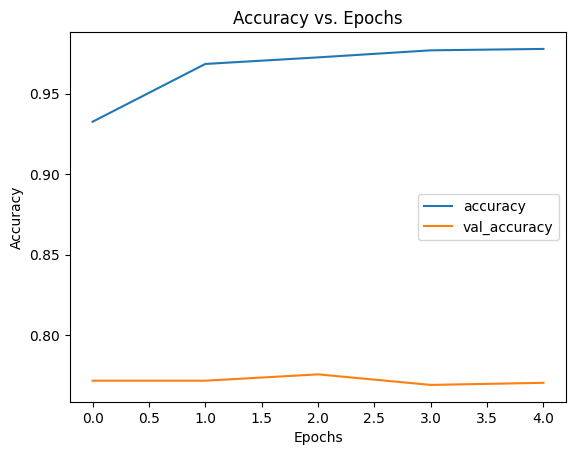

In [46]:
analysis.history.plot_history(model_3_history, 'accuracy')

In [47]:
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs[:10]

24/24 [==============================] - 0s 4ms/step


2023-08-28 17:27:36.770123: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-28 17:27:36.805634: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


array([[1.5395838e-03],
       [8.3597285e-01],
       [9.9971718e-01],
       [8.8650875e-02],
       [9.1782720e-05],
       [9.9956459e-01],
       [9.3220729e-01],
       [9.9992502e-01],
       [9.9984956e-01],
       [6.4778149e-01]], dtype=float32)

In [48]:
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [49]:
model_3_results = analysis.classification.generate_prediction_metrics(val_labels, model_3_preds)
model_3_results

PredictionMetrics(accuracy=0.7703412073490814, precision=0.7711671866902318, recall=0.7703412073490814, f1=0.7686901866564684)

In [50]:
np.array(list(dict(model_3_results).values())) >= np.array(list(dict(baseline_results).values()))

array([False, False, False, False])

#### Findings

Still haven't beat the baseline model :(

### Model-4: Bidirectional LSTM Model

Normal RNN's go from left to right, however, Bidirectional RNN's go from left to right as well as right to left. To summarize, it reads a sentence from left to right, then reads it from right to left.

NOTE: These are really only useful when going both directions can teach the network something useful when going both ways.

In [51]:
# Build out the Bidirectional Model

inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64))(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model_4 = tf.keras.models.Model(inputs, outputs, name='Model4BidirectionalLSTM')
model_4.summary()

Model: "Model4BidirectionalLSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 15)                0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirection  (None, 128)               98816     
 al)                                                             
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1378945 (5.26 MB)
Trainable p

In [52]:
# compile model
model_4.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [53]:
# Callback and Fit
# Fit the model with Tensorboard callback
# Setup Callbacks
tensorboard_callback_4 = modeling.callbacks.generate_tensorboard_callback('bidirectional-lstm-model', str(TENSORBOARD_LOGS_DIR))

model_4_history = model_4.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[tensorboard_callback_4])

INFO:py_learning_toolbox.deep_learning.modeling.callbacks:TensorBoard callback created.


Epoch 1/5


2023-08-28 17:27:37.917800: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-28 17:27:38.112259: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-28 17:27:38.124808: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-28 17:27:38.295651: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-28 17:27:38.313162: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


215/215 [==============================] - ETA: 0s - loss: 0.1097 - accuracy: 0.9701

2023-08-28 17:27:44.154769: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-28 17:27:44.229149: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-28 17:27:44.238227: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


215/215 [==============================] - 8s 29ms/step - loss: 0.1097 - accuracy: 0.9701 - val_loss: 1.0303 - val_accuracy: 0.7664
Epoch 2/5
215/215 [==============================] - 5s 24ms/step - loss: 0.0540 - accuracy: 0.9780 - val_loss: 1.0795 - val_accuracy: 0.7612
Epoch 3/5
215/215 [==============================] - 5s 22ms/step - loss: 0.0435 - accuracy: 0.9800 - val_loss: 1.4291 - val_accuracy: 0.7520
Epoch 4/5
215/215 [==============================] - 5s 22ms/step - loss: 0.0449 - accuracy: 0.9794 - val_loss: 1.1635 - val_accuracy: 0.7664
Epoch 5/5
215/215 [==============================] - 5s 22ms/step - loss: 0.0403 - accuracy: 0.9815 - val_loss: 1.4176 - val_accuracy: 0.7717


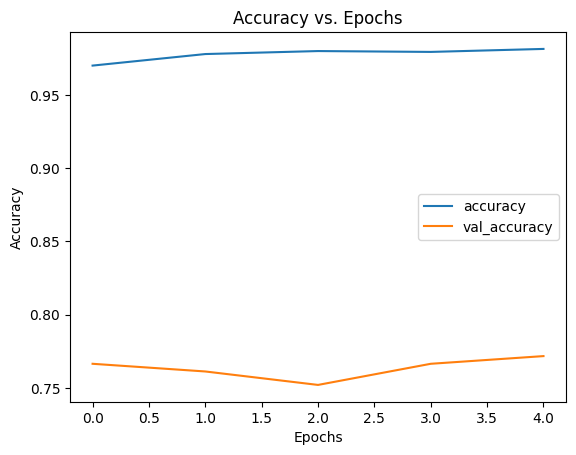

In [54]:
analysis.history.plot_history(model_4_history, 'accuracy')

In [55]:
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs[:10]

 1/24 [>.............................] - ETA: 9s

2023-08-28 17:28:04.561072: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-28 17:28:04.619821: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-28 17:28:04.629608: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


24/24 [==============================] - 1s 9ms/step


array([[4.4312604e-02],
       [7.4860013e-01],
       [9.9996459e-01],
       [1.3863783e-01],
       [1.3379288e-05],
       [9.9987960e-01],
       [9.9582374e-01],
       [9.9998295e-01],
       [9.9996519e-01],
       [9.9459708e-01]], dtype=float32)

In [56]:
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [57]:
model_4_results = analysis.classification.generate_prediction_metrics(val_labels, model_4_preds)
model_4_results

PredictionMetrics(accuracy=0.7716535433070866, precision=0.7719163531646017, recall=0.7716535433070866, f1=0.7703995252204568)

In [58]:
np.array(list(dict(model_4_results).values())) >= np.array(list(dict(baseline_results).values()))

array([False, False, False, False])

#### Findings

Looks like this performed worse than the LSTM and GRU.

### Model-5: 1D Convolutional Neural Network

We've used CNN's for images, but images are tpycally 2D, however, text data is 1D. 

The typical structure for Conv1D models:

```
Inputs -> Tokenization -> Embedding -> Layers (Conv1D + Pooling) -> Outputs
```

In [59]:
# build the model

inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = tf.keras.layers.Conv1D(filters=32, kernel_size=5, activation='relu', padding='valid')(x)
x = tf.keras.layers.GlobalMaxPool1D()(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model_5 = tf.keras.models.Model(inputs, outputs, name='Model5CNN1D')
model_5.summary()

Model: "Model5CNN1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 15)                0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 conv1d (Conv1D)             (None, 11, 32)            20512     
                                                                 
 global_max_pooling1d (Glob  (None, 32)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense_4 (Dense)             (None, 1)                 

In [60]:
# Compile model
model_5.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [61]:
# Callback and Fit
# Fit the model with Tensorboard callback
# Setup Callbacks
tensorboard_callback_5 = modeling.callbacks.generate_tensorboard_callback('conv-1d-model', str(TENSORBOARD_LOGS_DIR))

model_5_history = model_5.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[tensorboard_callback_5])

INFO:py_learning_toolbox.deep_learning.modeling.callbacks:TensorBoard callback created.


Epoch 1/5


2023-08-28 17:28:05.241674: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


215/215 [==============================] - ETA: 0s - loss: 0.1366 - accuracy: 0.9604

2023-08-28 17:28:09.544083: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


215/215 [==============================] - 5s 20ms/step - loss: 0.1366 - accuracy: 0.9604 - val_loss: 0.8447 - val_accuracy: 0.7808
Epoch 2/5
215/215 [==============================] - 3s 14ms/step - loss: 0.0774 - accuracy: 0.9730 - val_loss: 0.9701 - val_accuracy: 0.7677
Epoch 3/5
215/215 [==============================] - 3s 13ms/step - loss: 0.0615 - accuracy: 0.9764 - val_loss: 1.0659 - val_accuracy: 0.7677
Epoch 4/5
215/215 [==============================] - 3s 12ms/step - loss: 0.0563 - accuracy: 0.9761 - val_loss: 1.1396 - val_accuracy: 0.7625
Epoch 5/5
215/215 [==============================] - 3s 12ms/step - loss: 0.0513 - accuracy: 0.9796 - val_loss: 1.1610 - val_accuracy: 0.7559


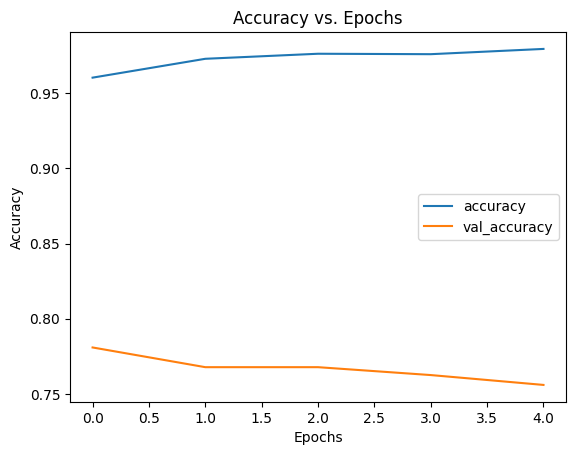

In [62]:
analysis.history.plot_history(model_5_history, 'accuracy')

In [63]:
model_5_pred_probs = model_5.predict(val_sentences)
model_5_pred_probs[:10]

24/24 [==============================] - 0s 4ms/step


2023-08-28 17:28:20.951501: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


array([[6.3674361e-01],
       [9.2291296e-01],
       [9.9994206e-01],
       [8.0362268e-02],
       [1.4912084e-07],
       [9.9966753e-01],
       [9.9624842e-01],
       [9.9999392e-01],
       [9.9999881e-01],
       [9.5831758e-01]], dtype=float32)

In [64]:
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [65]:
model_5_results = analysis.classification.generate_prediction_metrics(val_labels, model_5_preds)
model_5_results

PredictionMetrics(accuracy=0.7559055118110236, precision=0.7559055118110236, recall=0.7559055118110236, f1=0.7559055118110236)

In [66]:
np.array(list(dict(model_5_results).values())) >= np.array(list(dict(baseline_results).values()))

array([False, False, False, False])

#### Findings

Still not outperforming our Baseline Model.

### Model-6: TensorFlow Hub Pretrained Sentence Encoder

This model will use Transfer Learning with the `Universal Sentence Encoder` pretrained model on TensorFlow Hub (see link below).

* https://tfhub.dev/google/collections/universal-sentence-encoder/1

In [67]:
import tensorflow_hub as hub

In [68]:
use_url = 'https://tfhub.dev/google/universal-sentence-encoder/4'

In [69]:
# Testing out the transfer learning model
embed = hub.load(use_url)

embeddings = embed([
    "The quick brown fox jumps over the lazy dog.",
    "I am a sentence for which I would like to get its embedding"])

print(embeddings)

2023-08-28 17:28:22.814651: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-28 17:28:23.714164: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


tf.Tensor(
[[-0.03133017 -0.06338633 -0.01607502 ... -0.0324278  -0.04575741
   0.05370455]
 [ 0.05080861 -0.01652432  0.01573779 ...  0.00976656  0.0317012
   0.01788118]], shape=(2, 512), dtype=float32)


In [70]:
# Build Model

# Create a Keras Layer using the USE pretrained layer from TensorFlow Hub
sentence_encoder_layer = hub.KerasLayer(use_url, input_shape=[], dtype=tf.string, trainable=False, name='USE')

# Setup Layers
model_6 = tf.keras.models.Sequential([
    sentence_encoder_layer,
    tf.keras.layers.Dense(1, activation='sigmoid')], name='Model6USE')
model_6.summary()

2023-08-28 17:28:25.818164: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Model: "Model6USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 1)                 513       
                                                                 
Total params: 256798337 (979.61 MB)
Trainable params: 513 (2.00 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [71]:
# Compile model
model_6.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [72]:
# Callback and Fit
# Fit the model with Tensorboard callback
# Setup Callbacks
tensorboard_callback_6 = modeling.callbacks.generate_tensorboard_callback('use-model', str(TENSORBOARD_LOGS_DIR))

model_6_history = model_6.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[tensorboard_callback_6])

INFO:py_learning_toolbox.deep_learning.modeling.callbacks:TensorBoard callback created.


Epoch 1/5


2023-08-28 17:28:27.625557: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


215/215 [==============================] - ETA: 0s - loss: 0.6502 - accuracy: 0.7285

2023-08-28 17:28:41.902720: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


215/215 [==============================] - 19s 81ms/step - loss: 0.6502 - accuracy: 0.7285 - val_loss: 0.6127 - val_accuracy: 0.7717
Epoch 2/5
215/215 [==============================] - 13s 61ms/step - loss: 0.5821 - accuracy: 0.7884 - val_loss: 0.5634 - val_accuracy: 0.7730
Epoch 3/5
215/215 [==============================] - 12s 55ms/step - loss: 0.5390 - accuracy: 0.7943 - val_loss: 0.5317 - val_accuracy: 0.7835
Epoch 4/5
215/215 [==============================] - 11s 53ms/step - loss: 0.5101 - accuracy: 0.7989 - val_loss: 0.5104 - val_accuracy: 0.7848
Epoch 5/5
215/215 [==============================] - 11s 52ms/step - loss: 0.4897 - accuracy: 0.8003 - val_loss: 0.4957 - val_accuracy: 0.7861


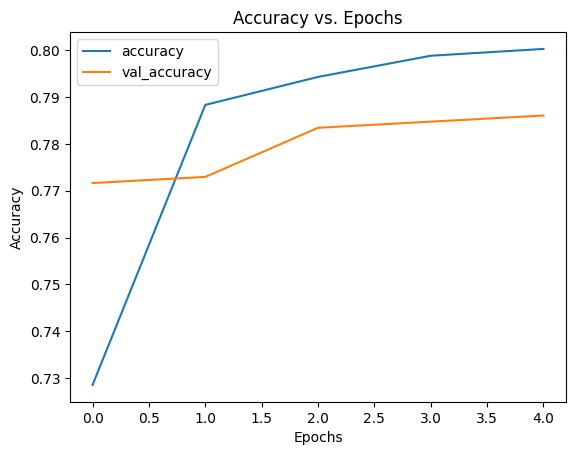

In [73]:
analysis.history.plot_history(model_6_history, 'accuracy')

In [74]:
model_6_pred_probs = model_6.predict(val_sentences)
model_6_pred_probs[:10]

2023-08-28 17:29:33.397527: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


24/24 [==============================] - 4s 161ms/step


array([[0.3917343 ],
       [0.68764436],
       [0.86730325],
       [0.34387174],
       [0.66290593],
       [0.7355277 ],
       [0.81603044],
       [0.8422261 ],
       [0.75106776],
       [0.21196915]], dtype=float32)

In [75]:
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [76]:
model_6_results = analysis.classification.generate_prediction_metrics(val_labels, model_6_preds)
model_6_results

PredictionMetrics(accuracy=0.7860892388451444, precision=0.7862161422078583, recall=0.7860892388451444, f1=0.7851501923128148)

In [77]:
np.array(list(dict(model_6_results).values())) >= np.array(list(dict(baseline_results).values()))

array([False, False, False, False])

#### Findings:

Looks like this model beat the baseline the first time I ran this, but it was very close and isn't guranteed to beat it every time due to randomness.

### Model-7: TF Hub Pretrained USE but w/ 10% of Training Data

Transfer learning helps when you don't have a large dataset. To see how our model performs on a smaller dataset, I am going to replicate model 6, but I will only train it on 10% of the data.

In [78]:
# Creating 10% subset of the training data
train_10_percent_split = int(0.1 * len(train_sentences))
train_sentences_10_percent = train_sentences[:train_10_percent_split]
train_labels_10_percent = train_labels[:train_10_percent_split]
len(train_sentences_10_percent), len(train_labels_10_percent)

(685, 685)

**NOTE**
When looking at the 10% sample, needed to verify that the subset is representative of the entire dataset.

In [79]:
pd.Series(np.array(train_labels_10_percent)).value_counts()

0    406
1    279
Name: count, dtype: int64

In [80]:
train_data_shuffled['target'].value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

In [81]:
# Build Model
model_7 = tf.keras.models.clone_model(model_6)
model_7.summary()

2023-08-28 17:29:39.760646: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Model: "Model6USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 1)                 513       
                                                                 
Total params: 256798337 (979.61 MB)
Trainable params: 513 (2.00 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [82]:
# Compile model
model_7.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [83]:
# Callback and Fit
# Fit the model with Tensorboard callback
# Setup Callbacks
tensorboard_callback_7 = modeling.callbacks.generate_tensorboard_callback('use-10-percent-model', str(TENSORBOARD_LOGS_DIR))

model_7_history = model_7.fit(train_sentences_10_percent,
                              train_labels_10_percent,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[tensorboard_callback_7])

INFO:py_learning_toolbox.deep_learning.modeling.callbacks:TensorBoard callback created.


Epoch 1/5


2023-08-28 17:29:41.458420: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


22/22 [==============================] - ETA: 0s - loss: 0.6867 - accuracy: 0.6000

2023-08-28 17:29:46.396180: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


22/22 [==============================] - 10s 413ms/step - loss: 0.6867 - accuracy: 0.6000 - val_loss: 0.6804 - val_accuracy: 0.6417
Epoch 2/5
22/22 [==============================] - 4s 189ms/step - loss: 0.6737 - accuracy: 0.7095 - val_loss: 0.6709 - val_accuracy: 0.6929
Epoch 3/5
22/22 [==============================] - 4s 163ms/step - loss: 0.6616 - accuracy: 0.7489 - val_loss: 0.6624 - val_accuracy: 0.7165
Epoch 4/5
22/22 [==============================] - 3s 155ms/step - loss: 0.6504 - accuracy: 0.7708 - val_loss: 0.6543 - val_accuracy: 0.7362
Epoch 5/5
22/22 [==============================] - 3s 135ms/step - loss: 0.6400 - accuracy: 0.7796 - val_loss: 0.6468 - val_accuracy: 0.7323


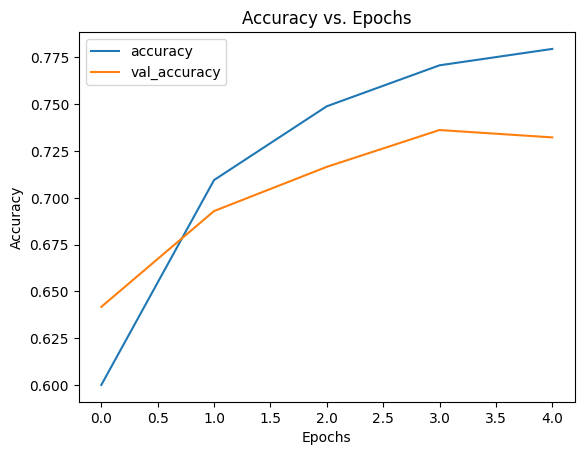

In [84]:
analysis.history.plot_history(model_7_history, 'accuracy')

In [85]:
model_7_pred_probs = model_7.predict(val_sentences)
model_7_pred_probs[:10]

2023-08-28 17:30:04.997982: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


24/24 [==============================] - 4s 166ms/step


array([[0.4438093 ],
       [0.5110339 ],
       [0.5353861 ],
       [0.45181847],
       [0.48908702],
       [0.5241308 ],
       [0.52880603],
       [0.5342965 ],
       [0.5348681 ],
       [0.4388381 ]], dtype=float32)

In [86]:
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [87]:
model_7_results = analysis.classification.generate_prediction_metrics(val_labels, model_7_preds)
model_7_results

PredictionMetrics(accuracy=0.7322834645669292, precision=0.7577545008763529, recall=0.7322834645669292, f1=0.7190126187800412)

In [88]:
np.array(list(dict(model_7_results).values())) >= np.array(list(dict(baseline_results).values()))

array([False, False, False, False])

#### Findings

Even with only 10% of the data, it performed only slightly worse than when training the model on 100% of the data.

## Comparing the Performance of Each Model

In [89]:
# Lets look at the combined performance of each model
all_model_results = pd.DataFrame({
    '0_baseline': dict(baseline_results),
    '1_simple_dense': dict(model_1_results),
    '2_lstm': dict(model_2_results),
    '3_gru': dict(model_3_results),
    '4_bidirectional': dict(model_4_results),
    '5_conv1d': dict(model_5_results),
    '6_tf_hub_use_encoder': dict(model_6_results),
    '7_tf_hub_use_encoder_10_percent': dict(model_7_results),
})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
0_baseline,0.792651,0.811139,0.792651,0.786219
1_simple_dense,0.780840,0.784870,0.780840,0.777979
2_lstm,0.776903,0.778956,0.776903,0.774752
3_gru,0.770341,0.771167,0.770341,0.768690
4_bidirectional,0.771654,0.771916,0.771654,0.770400
5_conv1d,0.755906,0.755906,0.755906,0.755906
6_tf_hub_use_encoder,0.786089,0.786216,0.786089,0.785150
7_tf_hub_use_encoder_10_percent,0.732283,0.757755,0.732283,0.719013


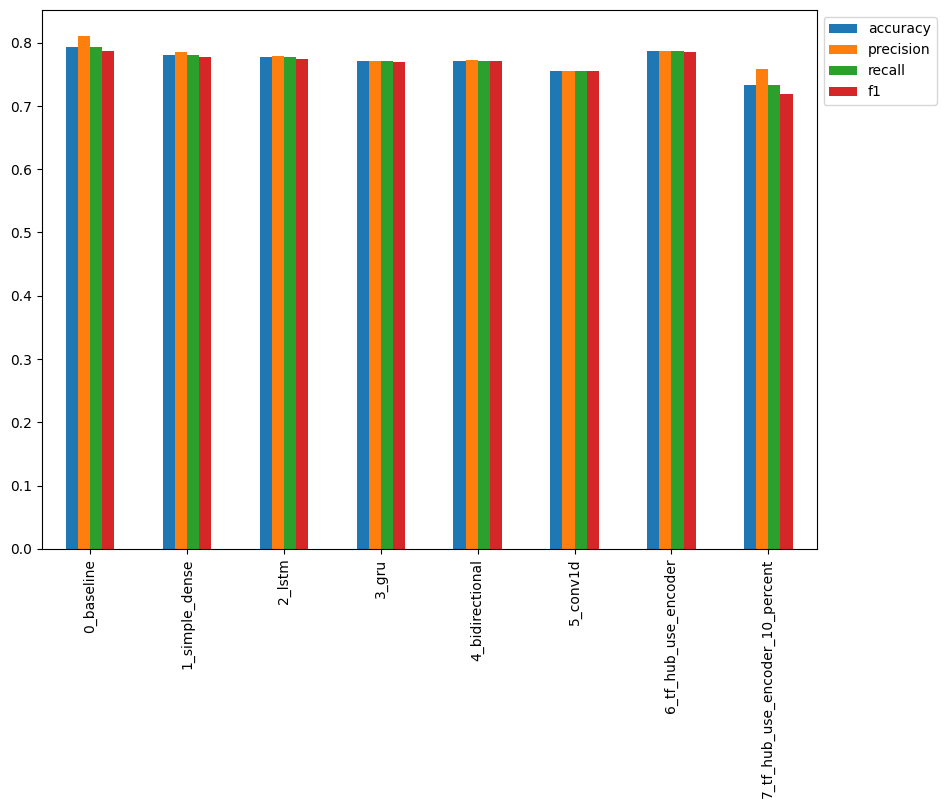

In [90]:
# Plot and compare all of the model results
all_model_results.plot(kind='bar', figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0))

<Axes: >

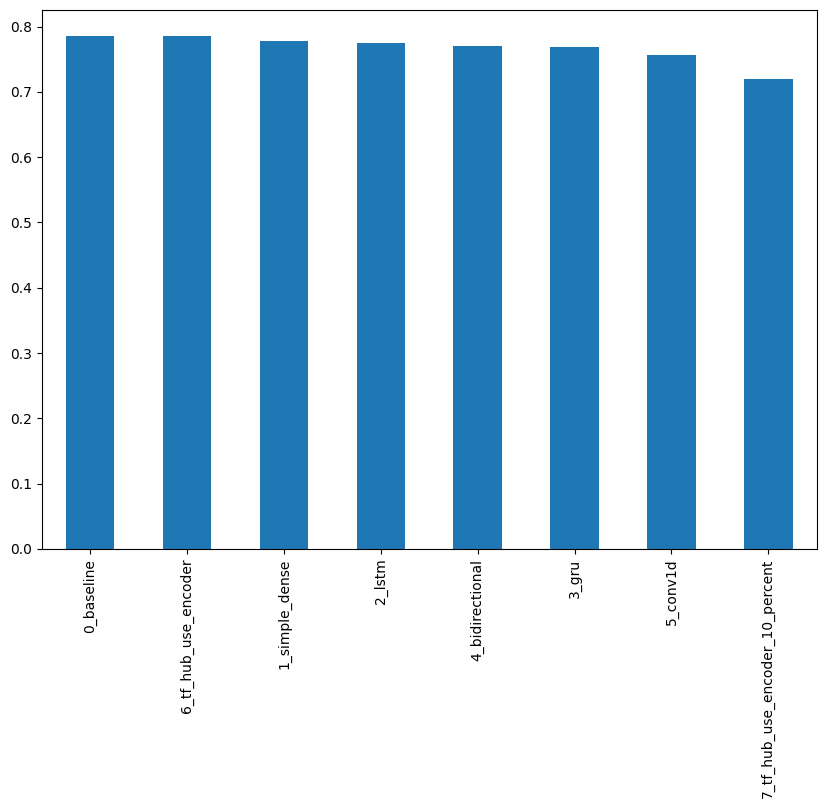

In [91]:
all_model_results.sort_values('f1', ascending=False)['f1'].plot(kind='bar', figsize=(10, 7))

### Finding Most Wrong Examples

* If our best model still isn't perfect, what examples is it getting wrong?
* And of these wrong examples, which ones is it getting *most* wrong.

For example if a sample should have a label of 0, but our model predicts a prediction probability of 0.999, that is pretty wrong.

To do this, I am going to look at Model 6 because that model performed the best.

In [93]:
model_6_pred_probs[:10], model_6_preds[:10]

(array([[0.3917343 ],
        [0.68764436],
        [0.86730325],
        [0.34387174],
        [0.66290593],
        [0.7355277 ],
        [0.81603044],
        [0.8422261 ],
        [0.75106776],
        [0.21196915]], dtype=float32),
 <tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>)

In [95]:
# CReateing DataFram with data
val_df = pd.DataFrame({
    'text': val_sentences,
    'target': val_labels,
    'pred': model_6_preds,
    'pred_prob': tf.squeeze(model_6_pred_probs)
})
val_df.head()

,text,target,pred,pred_prob
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.391734
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.687644
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.867303
3,@camilacabello97 Internally and externally scr...,1,0.0,0.343872
4,Radiation emergency #preparedness starts with ...,1,1.0,0.662906


In [100]:
# Find wrong predictions and sort by prediction probs
most_wrong = val_df[val_df['target'] != val_df['pred']].sort_values('pred_prob', ascending=False)
most_wrong[:10]

,text,target,pred,pred_prob
49,@madonnamking RSPCA site multiple 7 story high...,0,1.0,0.812562
31,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.770391
393,@SonofLiberty357 all illuminated by the bright...,0,1.0,0.752289
759,FedEx will no longer transport bioterror patho...,0,1.0,0.715734
181,Article by Michael Jackman at Metro Times Detr...,0,1.0,0.697522
109,[55436] 1950 LIONEL TRAINS SMOKE LOCOMOTIVES W...,0,1.0,0.692754
117,Public Hearing on 2015-16 @SUNY_Orange budget ...,0,1.0,0.687854
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.687644
80,GENERAL AUDIENCE: On Wounded Families | ZENIT ...,0,1.0,0.679682
209,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0,1.0,0.669476


In [101]:
most_wrong[-10:]

,text,target,pred,pred_prob
248,Until my death I'll forever rep the Jets.,1,0.0,0.183757
408,@willienelson We need help! Horses will die!Pl...,1,0.0,0.182937
722,Indeed!! I am fully aware of that battle! I su...,1,0.0,0.178459
244,Reddit Will Now QuarantineÛ_ http://t.co/pkUA...,1,0.0,0.171894
681,'The way you move is like a full on rainstorm ...,1,0.0,0.169393
536,@DavidVonderhaar At least you were sincere ??,1,0.0,0.165195
352,@reriellechan HE WAS THE LICH KING'S FIRST CAS...,1,0.0,0.160439
23,Ron &amp; Fez - Dave's High School Crush https...,1,0.0,0.159523
233,I get to smoke my shit in peace,1,0.0,0.132764
411,@SoonerMagic_ I mean I'm a fan but I don't nee...,1,0.0,0.119541


In [104]:
for row in most_wrong[-10:].itertuples():
    _, text, target, pred, pred_prob = row
    print(f'Target: {target}, Pred: {pred}, Prob: {pred_prob}')
    print('Text: ', text)
    print('-' * 80)

Target: 1, Pred: 0.0, Prob: 0.1837565004825592
Text:  Until my death I'll forever rep the Jets.
--------------------------------------------------------------------------------
Target: 1, Pred: 0.0, Prob: 0.18293672800064087
Text:  @willienelson We need help! Horses will die!Please RT &amp; sign petition!Take a stand &amp; be a voice for them! #gilbert23 https://t.co/e8dl1lNCVu
--------------------------------------------------------------------------------
Target: 1, Pred: 0.0, Prob: 0.17845897376537323
Text:  Indeed!! I am fully aware of that battle! I support you in that fight!!  https://t.co/MctJnZX4H8
--------------------------------------------------------------------------------
Target: 1, Pred: 0.0, Prob: 0.17189377546310425
Text:  Reddit Will Now QuarantineÛ_ http://t.co/pkUAMXw6pm #onlinecommunities #reddit #amageddon #freespeech #Business http://t.co/PAWvNJ4sAP
--------------------------------------------------------------------------------
Target: 1, Pred: 0.0, Prob: 0.169

## Making Predictios on Test Dataset

In [106]:
test_data

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


In [109]:
test_sentences = test_data['text'].to_list()
test_samples = random.sample(test_sentences, 10)

for test_sample in test_samples:
    pred_prob = tf.squeeze(model_6.predict([test_sample]))
    pred = tf.round(pred_prob)

    print(f'Pred: {int(pred)}, Prob: {pred_prob}')
    print('Text: ', test_sample)
    print('-' * 80, '\n')

1/1 [==============================] - 1s 1s/step
Pred: 1, Prob: 0.8487718105316162
Text:  3 former executives to be prosecuted in Fukushima nuclear disaster http://t.co/EmWU8Xksdu
-------------------------------------------------------------------------------- 

1/1 [==============================] - 0s 245ms/step
Pred: 1, Prob: 0.5787045955657959
Text:  #Turkey invades #Israel - Halfway to #Armageddon http://t.co/xUOh3sJNXF
-------------------------------------------------------------------------------- 

1/1 [==============================] - 0s 159ms/step
Pred: 0, Prob: 0.1815175712108612
Text:  Do you feel deluged by unhappiness? Take the quiz: http://t.co/XUyfZkZ4k0 http://t.co/YupKvDIh8m
-------------------------------------------------------------------------------- 

1/1 [==============================] - 0s 117ms/step
Pred: 0, Prob: 0.20980007946491241
Text:  SALHA(1):HARRY STYLES(2)U KNOW WHERE IS UR P_EOPLE#HURRY#EVACUATE THEM FROM#HELL.#JUST SHAHADA&amp;'PICK#ME'.#CLASS_SI

## Speed vs. Score Tradeoff

In [110]:
import time

def pred_timer(model, samples):
    """
        Timer for how long a model takes to make predictions on samples.
    """
    start_time = time.perf_counter()
    model.predict(samples)
    end_time = time.perf_counter()
    total_time = end_time - start_time
    time_per_pred = total_time / len(samples)

    return total_time, time_per_pred

In [111]:
model_6_pred_time, model_6_time_per_pred = pred_timer(model_6, val_sentences)
model_6_pred_time, model_6_time_per_pred

24/24 [==============================] - 2s 70ms/step


(2.064795833000062, 0.0027097058175853833)

In [112]:
model_0_pred_time, model_0_time_per_pred = pred_timer(model_0, val_sentences)
model_0_pred_time, model_0_time_per_pred

(0.030921540999770514, 4.057945013093243e-05)

Text(0.5, 1.0, 'F1-score vs. Time per prediction')

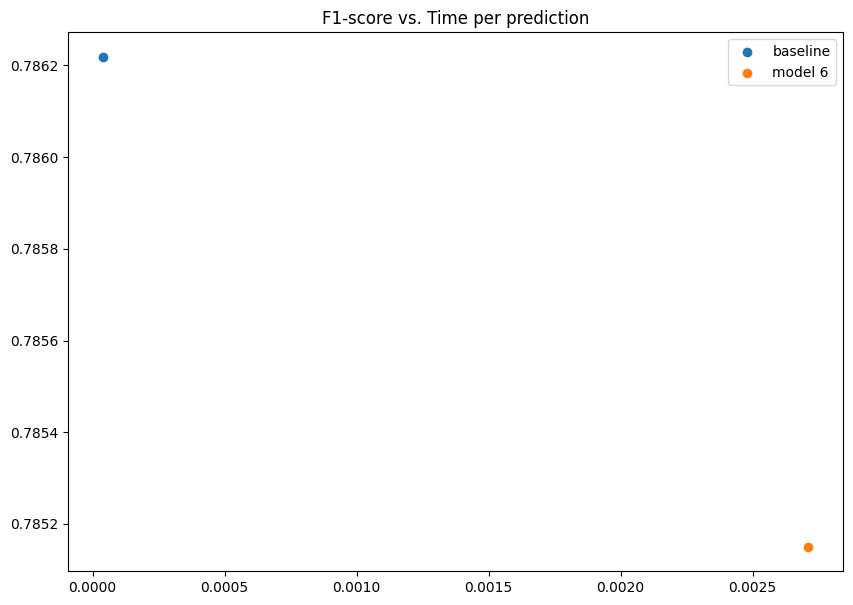

In [115]:
plt.figure(figsize=(10,7))
plt.scatter(model_0_time_per_pred, baseline_results.f1, label='baseline')
plt.scatter(model_6_time_per_pred, model_6_results.f1, label='model 6')
plt.legend()
plt.title('F1-score vs. Time per prediction')

#### Findings

When comparing out best model against our baseline model, the time difference is significant, even though the `F1` is virtually identical.